In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import PySCFPeriodicDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

In [194]:
tcb = mts.load('/home/pegolo/Downloads/target_coupled_blocks')
ocb = mts.load('/home/pegolo/Downloads/overlap_coupled_blocks')
fea = mts.load('/home/pegolo/Downloads/all_features')

In [8]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(tcb,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(tcb, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(ocb,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_overlaps = mts.split(ocb, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(fea, axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(fea, split_by_axis, grouped_labels)

In [20]:
ml_data = IndexedDataset(descriptor = split_features,
                         target = split_target,
                         overlap = split_overlaps,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])
batch_size = 1

overnorms = [torch.stack([dataset.fock_realspace[ifr][T]*dataset.overlap_realspace[ifr][T] for T in dataset.fock_realspace[ifr]]).sum() for ifr in range(len(dataset))]

dataloader = DataLoader(ml_data,
                        batch_size = batch_size,
                        shuffle = False,
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


In [30]:
for batch in dataloader:
    print(batch.sample_id[0])
    pred = model.predict_batch(batch.descriptor, batch.target)
    for (k, p), t in zip(pred.items(), batch.target.blocks()):
        assert p.samples == t.samples, k

0
1


AssertionError: LabelsEntry(block_type=-1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)

In [39]:
for i, ((k, p), t) in enumerate(zip(pred.items(), batch.target.blocks())):
    if not p.samples == t.samples:
        print(i, k.values)
        print(p.samples.values.shape, t.samples.values.shape)
        print()

0 tensor([-1,  6,  1,  0,  6,  2,  0,  0], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

1 tensor([-1,  6,  1,  0,  6,  2,  1,  1], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

2 tensor([-1,  6,  2,  0,  6,  2,  1,  1], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

3 tensor([-1,  6,  2,  1,  6,  2,  1,  1], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

11 tensor([1, 6, 1, 0, 6, 1, 0, 0], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

12 tensor([1, 6, 1, 0, 6, 2, 0, 0], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

13 tensor([1, 6, 1, 0, 6, 2, 1, 1], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

14 tensor([1, 6, 2, 0, 6, 2, 0, 0], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

15 tensor([1, 6, 2, 0, 6, 2, 1, 1], dtype=torch.int32)
torch.Size([3144, 6]) torch.Size([3125, 6])

16 tensor([1, 6, 2, 1, 6, 2, 1, 0], dtype=torch.int32)
torch.Size([3144,

In [41]:
inter, m1, m2 = pred[0].samples.intersection_and_mapping(batch.target[0].samples)

In [44]:
pred[0].samples.values[m1==-1]

tensor([[ 1,  3, 13,  2, -2,  1],
        [ 1,  6,  7,  1, -1, -2],
        [ 1,  6,  7,  1,  0, -2],
        [ 1,  6,  9,  1,  0, -2],
        [ 1,  6, 10,  1, -1, -2],
        [ 1,  6, 10,  1,  0, -2],
        [ 1,  6, 10,  2, -2, -1],
        [ 1,  6, 13,  2, -2, -1],
        [ 1,  6, 15,  1,  0, -2],
        [ 1,  7,  8, -1,  0,  2],
        [ 1,  7, 11, -1,  0,  2],
        [ 1,  7, 11, -1,  1,  2],
        [ 1,  7, 14, -1,  0,  2],
        [ 1,  8, 10,  1,  0, -2],
        [ 1,  9, 11, -1,  0,  2],
        [ 1, 10, 11, -1,  0,  2],
        [ 1, 10, 11, -1,  1,  2],
        [ 1, 10, 14, -1,  0,  2],
        [ 1, 11, 15,  1,  0, -2]], dtype=torch.int32)

In [48]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# QC dataset

In [190]:
aaaaa = PySCFPeriodicDataset(frames = frames, 
                               dimension = 2,
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

/home/pegolo/Software/mlelec/src/mlelec/data/dataset.py:878: UserWarning: Target not provided. ARE YOU DUMB OR WHAT???????? Get your life together you complete piece of crap. 
  raise IOError("At least one between fock_realspace and fock_kspace must be provided.")
/home/pegolo/Software/mlelec/src/mlelec/data/dataset.py:894: UserWarning: Overlap matrices not provided
  self.overlap_realspace = None


In [189]:
382//20

19

In [57]:
workdir = './'
START = 0 
STOP = 10
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rfock0 =[np.load(f'{data_dir}/nscf/realfock_{i}.npy', allow_pickle=True).item() for i in range(START, STOP)]

kmesh = [1,1,1]

for f in frames:
    f.wrap(center = (0,0,0), eps = 1e-60)

for K, K0 in zip(rfock, rfock0):
    for T in K:
        K[T] -= K0[T]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [149]:
workdir = './'
# workdir = '/home/nigam/scratch/MAC'
# root = f'{workdir}/data/hamiltonian/periodic/carbon_allotropes/'
root = f'{workdir}/examples/data/periodic/carbon_allotropes'
ORBS = 'sto-3g'
kmesh = np.loadtxt(f'{root}/kmesh.dat', dtype=int)
fermi = np.loadtxt(f'{root}/fermi.dat')
START = 20
STOP = 23

indices = kmesh[:,0][START:STOP]
kmesh = kmesh[:,1:][START:STOP].tolist()
fermi = fermi[:, 1][START:STOP]

frames = [read(f'{root}/{i}/cell_{i}.xyz') for i in indices]
    
rfock=[np.load(f'{root}/{i}/realfock_{i}.npy', allow_pickle=True).item() for i in indices ]
rover=[np.load(f'{root}/{i}/realoverlap_{i}.npy', allow_pickle=True).item() for i in indices ]
rfock0=[np.load(f'{root}/{i}/realnscffock_{i}.npy', allow_pickle=True).item() for i in indices ]

for f in frames:
    f.wrap(center = (0,0,0), eps = 1e-60)

for K, K0 in zip(rfock, rfock0):
    for T in K:
        K[T] -= K0[T]
# for f, o, E_f in zip(rfock, rover, fermi):
#     for T in f:
#         f[T] -= E_f*o[T]

In [150]:
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 3,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [151]:
cutoff = 8

In [152]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')

In [164]:
# k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff)
# k_target_coupled_blocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff = cutoff), skip_symmetry = True, device = device, translations= False)

In [30]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)
k_target_coupled_blocks = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [34]:
rHT = blocks_to_matrix(target_coupled_blocks, dataset)
rHk_BS = dataset.bloch_sum(rHT)

In [ ]:
rHk = kblocks_to_matrix(k_target_blocks, dataset)

In [33]:
for T in rHT[0]:
    print(torch.norm(rHT[0][T]-dataset.fock_realspace[0][T]))

tensor(6.6368e-21)
tensor(6.6368e-21)
tensor(4.7413e-17)
tensor(4.7413e-17)
tensor(6.5868e-21)
tensor(6.5868e-21)
tensor(3.7597e-17)
tensor(3.7597e-17)
tensor(2.2824e-15)
tensor(2.2824e-15)
tensor(3.4284e-17)
tensor(3.4284e-17)
tensor(7.0293e-21)
tensor(7.0293e-21)
tensor(4.4918e-17)
tensor(4.4918e-17)
tensor(6.7395e-21)
tensor(6.7395e-21)
tensor(3.7742e-17)
tensor(3.7742e-17)
tensor(2.2717e-15)
tensor(2.2717e-15)
tensor(3.5866e-17)
tensor(3.5866e-17)
tensor(1.7019e-15)
tensor(1.7019e-15)
tensor(1.2506e-13)


# Features

In [153]:
max_radial  = 8
max_angular = 6
atomic_gaussian_width = 0.3

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [154]:
features[0]

TensorBlock
    samples (720): ['structure', 'center', 'neighbor', 'cell_shift_a', 'cell_shift_b', 'cell_shift_c']
    components (1): ['spherical_harmonics_m']
    properties (448): ['species_neighbor_a', 'n_1_a', 'k_2', 'species_neighbor_1_b', 'n_1_b', 'l_2']
    gradients: None

In [155]:
features = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)
# rhonui, rhoij = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT)

cpu pair features
cpu single center features
cpu single center features


In [10]:
features.save(f'{root}/feat_5')

In [74]:
from mlelec.features.acdc import pair_features, single_center_features

In [72]:
%lprun -f pair_features pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = False, both_centers = False, kmesh = dataset.kmesh, device = device, lcut = 3, return_rho0ij = False)  

cpu pair features
cpu single center features


Timer unit: 1e-09 s

Total time: 36.841 s
File: /home/pegolo/Software/mlelec/src/mlelec/features/acdc.py
Function: pair_features at line 85

Line #      Hits         Time  Per Hit   % Time  Line Contents
    85                                           def pair_features(
    86                                               frames: List[ase.Atoms],
    87                                               hypers: Dict,
    88                                               hypers_pair: Dict = None,
    89                                               cg=None,
    90                                               rhonu_i: TensorMap = None,
    91                                               order_nu: Union[
    92                                                   List[int], int
    93                                               ] = None,  # List - useful when combining nu on i and nu' on j
    94                                               all_pairs: bool = False,
    95                    

In [75]:
%lprun -f single_center_features single_center_features(dataset.structures, hypers_atom, order_nu = 2, lcut = 3, device = device, feature_names = rhoij.property_names)

cpu single center features


Timer unit: 1e-09 s

Total time: 1.65911 s
File: /home/pegolo/Software/mlelec/src/mlelec/features/acdc.py
Function: single_center_features at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def single_center_features(
    34                                               frames, hypers, order_nu, lcut=None, cg=None, device="cpu", **kwargs
    35                                           ):  
    36         1      74851.0  74851.0      0.0      print(device, 'single center features')
    37         1    4252477.0    4e+06      0.3      calculator = SphericalExpansion(**hypers)
    38         1    5319420.0    5e+06      0.3      rhoi = calculator.compute(rascaline.torch.systems_to_torch(frames), use_native_system = use_native)
    39         1   32274338.0    3e+07      1.9      rho1i = acdc_standardize_keys(rhoi)
    40         1     898005.0 898005.0      0.1      rho1i = rho1i.keys_to_properties(["species_neighbo

In [58]:
from mlelec.features.acdc import twocenter_features_periodic_NH
features = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = False)

(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)
(0, 0, 0, 0, 0, 0) tensor([ 0,  0,  1, -1,  0,  0,  1], dtype=torch.int32)


## Features encoder

In [13]:
import torch.nn as nn
from mlelec.models.linear import MLP

class featmodel(nn.Module):
    def __init__(self,
                 features,
                 device=None,
                 apply_norm = False, 
                 **kwargs):

        super().__init__()
        self.features = features 
        self.apply_norm = apply_norm
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else: 
            self.device = device
        self._submodels(set_bias=kwargs.get("bias", False), **kwargs)

    def _submodels(self, set_bias=False, **kwargs):
        self.blockmodels = {}
        for k, feat in self.features.items():
            bias = False
            if k["spherical_harmonics_l"] == 0 and set_bias:
                bias = True
            self.blockmodels[str(tuple(k))] = MLP(
                nin=feat.values.shape[-1],
                nout=feat.values.shape[-1],
                nhidden=kwargs.get("nhidden", 16),
                nlayers=kwargs.get("nlayers", 2),
                bias=bias,
                activation=kwargs.get("activation", None),
                
                # activation_with_linear=kwargs.get("activation_with_linear", False),
                apply_layer_norm=self.apply_norm,
            )
        self.model = torch.nn.ModuleDict(self.blockmodels)
        self.model.to(self.device)

    def forward(self, features = None):
        pred_blocks = []
        if features is None:
            features = self.features
        keys = features.keys
        preds=[]
        for k, feat in features.items():
            pred = self.blockmodels[str(tuple(k))](feat.values)
            # preds.append(pred)
            pred_blocks.append(
                    TensorBlock(
                        values = pred,#.reshape((nsamples, ncomp, 1)),
                        samples = feat.samples,
                        components = feat.components,
                        properties = feat.properties,
                    )
                )
            pred = None
        
        # # del features
        return TensorMap(keys, pred_blocks)
        # return preds

In [47]:
fmodel = featmodel(
    features, 
    apply_norm=True, 
    nhidden=[100,50,25,50,100],
    nlayers = 5,
    activation = 'SiLU',
    bias=True,
    device=device
)

In [48]:
fmodel = fmodel.double()

nepoch = 1000

optimizers = []
schedulers = []
for i, key in enumerate(fmodel.model):
    optimizers.append(torch.optim.Adam(fmodel.model[key].parameters(), lr = 1e-3)) #, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100, verbose=True))

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
from metatensor.learn import Dataset, DataLoader, IndexedDataset
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts
import metatensor.torch as mts
from mlelec.data.dataset import split_by_Aij
from mlelec.metrics import L2_loss

In [17]:
split_by_axis = "samples"
split_by_dimension = "structure"


grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [18]:
ml_data = IndexedDataset(descriptor = split_features, target = split_features, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

In [52]:
batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, 
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


In [53]:
LOSS_LIST = []

fmodel.train(True)

nepoch = 1000

for epoch in range(nepoch):
    LOSS = 0
    lr = []
    for ib, batch in enumerate(dataloader):
    # if True:
        for ik, key in enumerate(fmodel.model):
            optimizers[ik].zero_grad()
        
        pred = fmodel.forward(batch.descriptor)
        # pred = mts.detach(pred)

        # all_losses = [torch.norm(p - t.values)**2 for p, t in zip(pred, batch.target.blocks())]
        
        # Compute the loss for each block
        # all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
        # all_losses = [b.values.sum() for b in mts.pow(mts.subtract(pred, features), 2).blocks()]
        all_losses = [b.values.sum() for b in mts.pow(mts.subtract(pred, batch.target), 2).blocks()]
        epoch_loss = sum(all_losses).item()

        # # Total loss
        # epoch_loss = epoch_loss.item()
        LOSS += epoch_loss

        # # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, fmodel.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(fmodel.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            lr.append(schedulers[ik].get_last_lr())
        pred = None
    if epoch % 1 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr):e}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

0
1
2
3
4
5
6
7
8
9
Epoch       0, train loss 230336.3355008756, avg lr = 1.000000e-03
10
11
12
13
14
15
16
17
18
19
Epoch       1, train loss 77904.1096147080, avg lr = 1.000000e-03
20
21
22
23
24
25
26
27
28
29
Epoch       2, train loss 25551.8496585524, avg lr = 1.000000e-03
30
31
32
33
34
35
36
37
38
39
Epoch       3, train loss 10850.6651731825, avg lr = 1.000000e-03
40
41
42
43
44
45
46
47
48
49
Epoch       4, train loss 8234.3167935514, avg lr = 1.000000e-03
50
51
52
53
54
55
56
57
58
59
Epoch       5, train loss 6218.9029183814, avg lr = 1.000000e-03
60
61
62
63
64
65
66
67
68
69
Epoch       6, train loss 3701.4842569141, avg lr = 1.000000e-03
70
71
72
73
74
75
76
77
78
79
Epoch       7, train loss 2722.1607762002, avg lr = 1.000000e-03
80
81
82
83
84
85
86
87
88
89
Epoch       8, train loss 1921.4624895466, avg lr = 1.000000e-03
90
91
92
93
94
95
96
97
98
99
Epoch       9, train loss 1701.9677207885, avg lr = 1.000000e-03
100
101
102
103
104
105
106
107
108
109
Epoch      10, 


KeyboardInterrupt



# ML Dataset/Dataloader

In [76]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks, 
                                                                                                                  axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks, 
                                                                                                                  axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, 
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [77]:
ml_data = IndexedDataset(descriptor = split_features, 
                         target = split_target, 
                         overlap = split_overlaps,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

Split kspace targets

In [17]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(k_target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target_k = mts.split(k_target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features_k = mts.split(features, split_by_axis, grouped_labels)

In [18]:
ml_data_k = IndexedDataset(descriptor = split_features_k, target = split_target_k, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

# Ridge regression

In [78]:
from mlelec.models.linear import LinearModelPeriodic

In [79]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [80]:
model_ridge = LinearModelPeriodic(twocfeat = features, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-9, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0017)


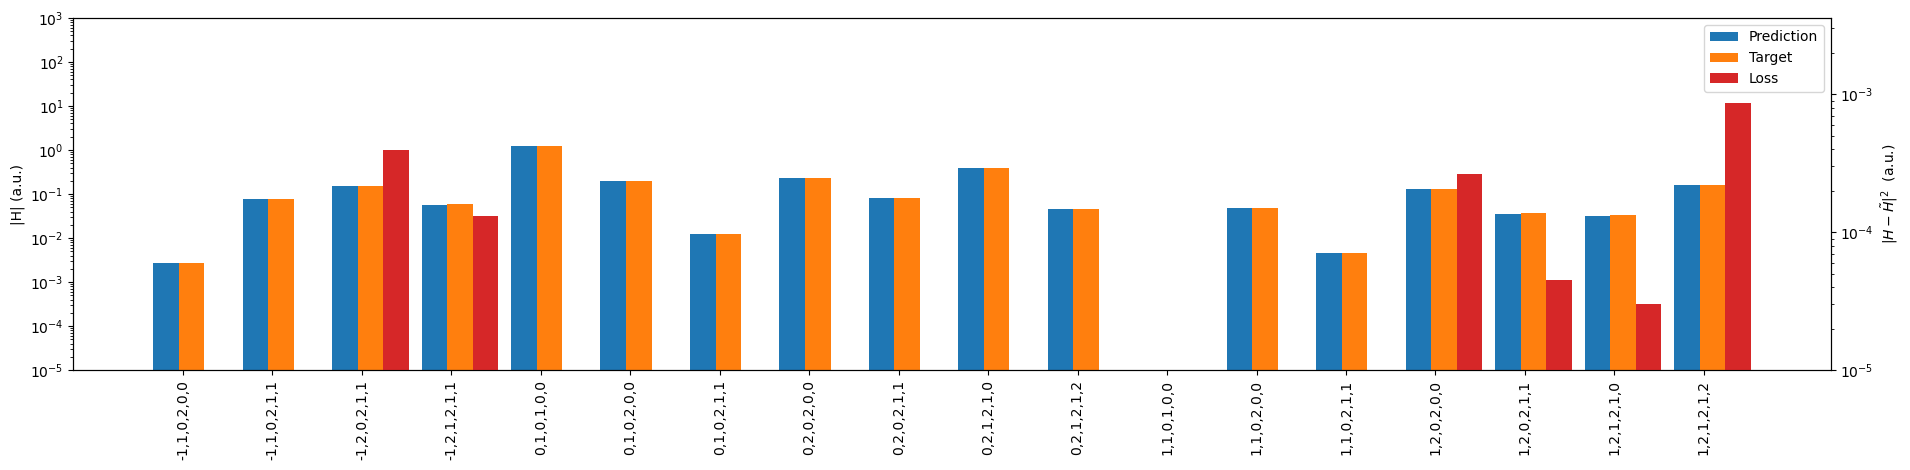

In [81]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

# Train

In [82]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

In [11]:
features = fea
target_coupled_blocks = tcb

In [128]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = features, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 32, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

nepoch = 1000

In [129]:
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 5e-4)) #, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100))

In [130]:
from metatensor.learn import DataLoader

batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))
# dataloader_k = DataLoader(ml_data_k, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [131]:
overnorms = [torch.stack([dataset.fock_realspace[ifr][T]*dataset.overlap_realspace[ifr][T] for T in dataset.fock_realspace[ifr]]).sum() for ifr in range(len(dataset))]

In [132]:
loss_fn = L2_loss_meanzero

In [133]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

nepoch = 50000
for epoch in range(nepoch):

    if epoch >= 100000:
        train_kspace = True

    if not train_kspace:
        # Train against real space targets
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader):
            
            model.train(True)
            
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor, batch.target)
            
            # Compute the loss for each block
            all_losses, epoch_loss = loss_fn(pred, batch.target, loss_per_block = True, norm = overnorms[batch.sample_id[0]], overlap = batch.overlap)
            # all_losses, epoch_loss = loss_fn(pred, batch.target, loss_per_block = True)
    
            # Total loss
            epoch_loss = epoch_loss.item()
            LOSS += epoch_loss
    
            # Loop through submodels and backpropagate
            for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
                loss.backward(retain_graph = False)
                torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 2)
                optimizers[ik].step()
                schedulers[ik].step(loss)
                lr.append(schedulers[ik].get_last_lr())
    else:
        # Train against k-space targets
    
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader_k):

            model.train(True)
    
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor)
            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            
            # Compute the loss
            loss = L2_loss(pred_kspace, batch.target, norm = 2*np.prod(dataset.kmesh[0]))
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))
                lr.append(schedulers[ik].get_last_lr())

    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss 1428.5066017362, avg lr = 0.0005000000000000001
Epoch       1, train loss  633.5036336786, avg lr = 0.0005000000000000001
Epoch       2, train loss  351.8627442027, avg lr = 0.0005000000000000001
Epoch       3, train loss   93.4689271340, avg lr = 0.0005000000000000001
Epoch       4, train loss   36.7932085525, avg lr = 0.0005000000000000001
Epoch       5, train loss   24.7183651944, avg lr = 0.0005000000000000001
Epoch       6, train loss    7.0958098836, avg lr = 0.0005000000000000001
Epoch       7, train loss   60.6261501239, avg lr = 0.0005000000000000001
Epoch       8, train loss   14.5771718961, avg lr = 0.0005000000000000001
Epoch       9, train loss   36.7266239273, avg lr = 0.0005000000000000001
Epoch      10, train loss    4.6030988742, avg lr = 0.0005000000000000001
Epoch      11, train loss   18.2908260654, avg lr = 0.0005000000000000001
Epoch      12, train loss   28.1460964030, avg lr = 0.0005000000000000001
Epoch      13, train loss   21.4929333

KeyboardInterrupt: 

(280, 280)

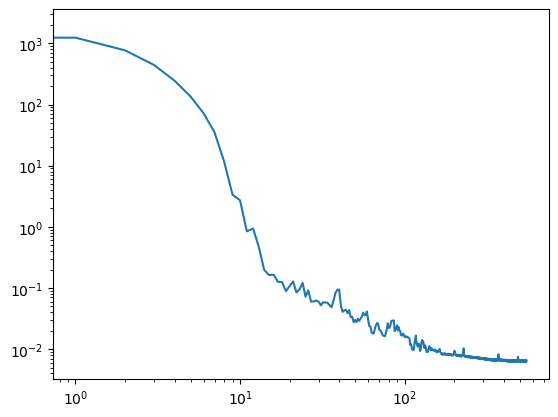

In [97]:
plt.loglog(LOSS_LIST)

In [47]:
k

LabelsEntry(block_type=-1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)

In [48]:
map_targetkeys_to_featkeys?

Signature:
map_targetkeys_to_featkeys(
    features,
    key,
    cell_shift=None,
    return_key=False,
)
Docstring: <no docstring>
File:      ~/Software/mlelec/src/mlelec/utils/twocenter_utils.py
Type:      function

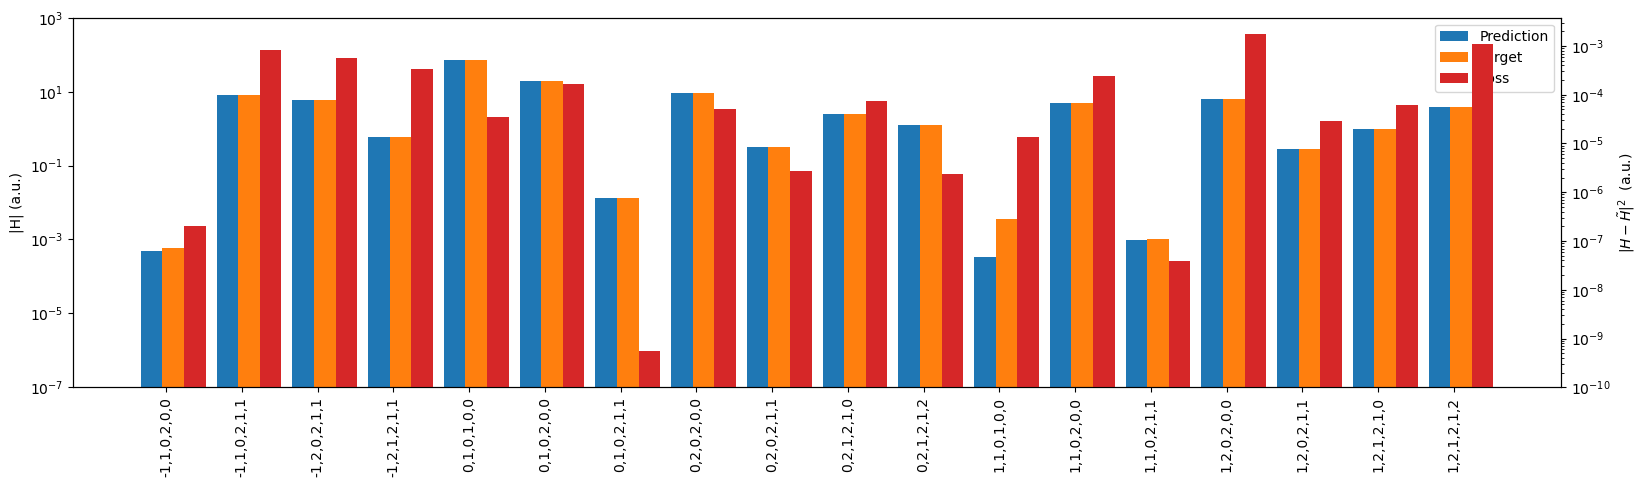

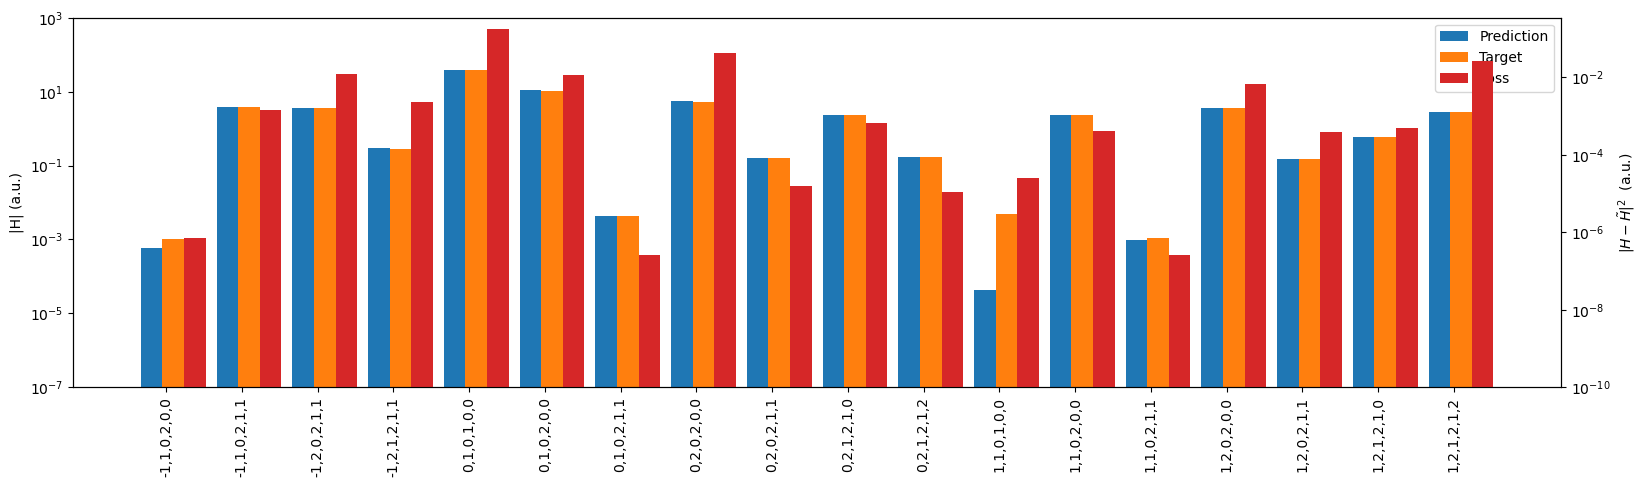

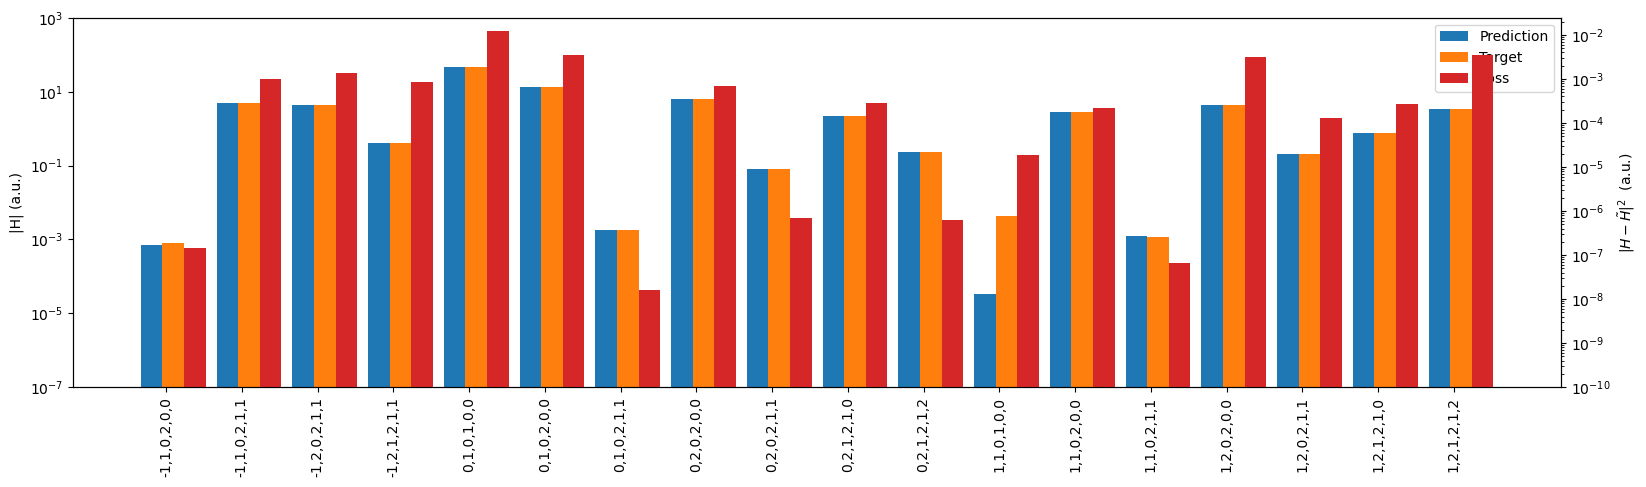

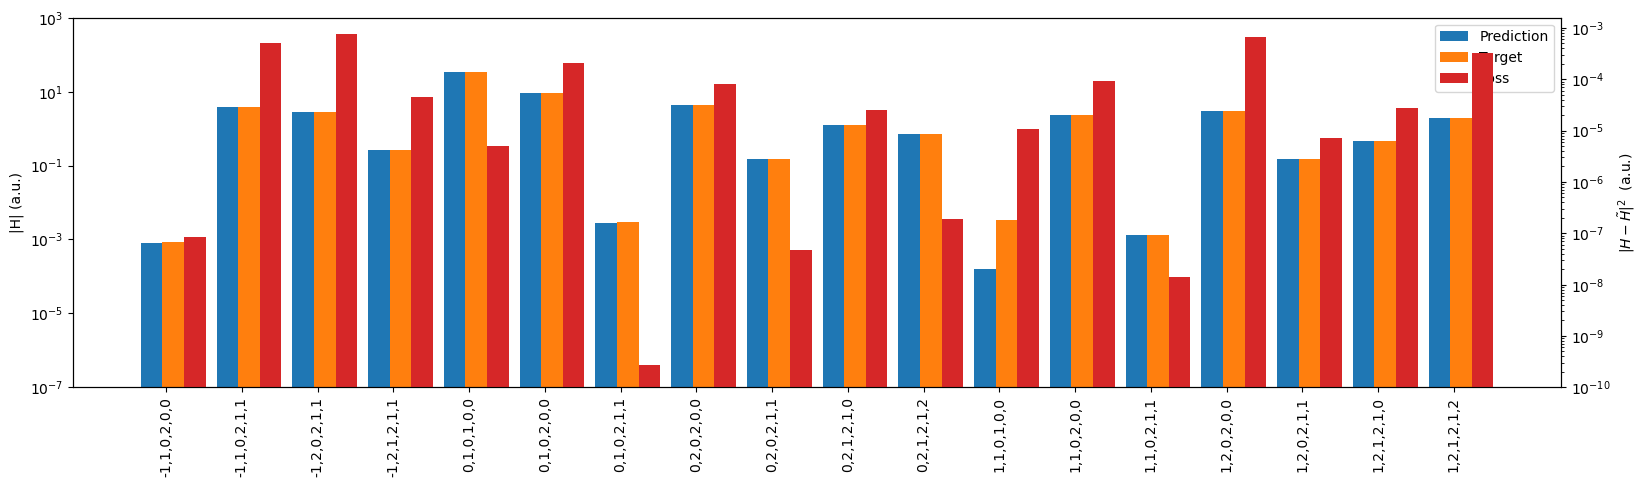

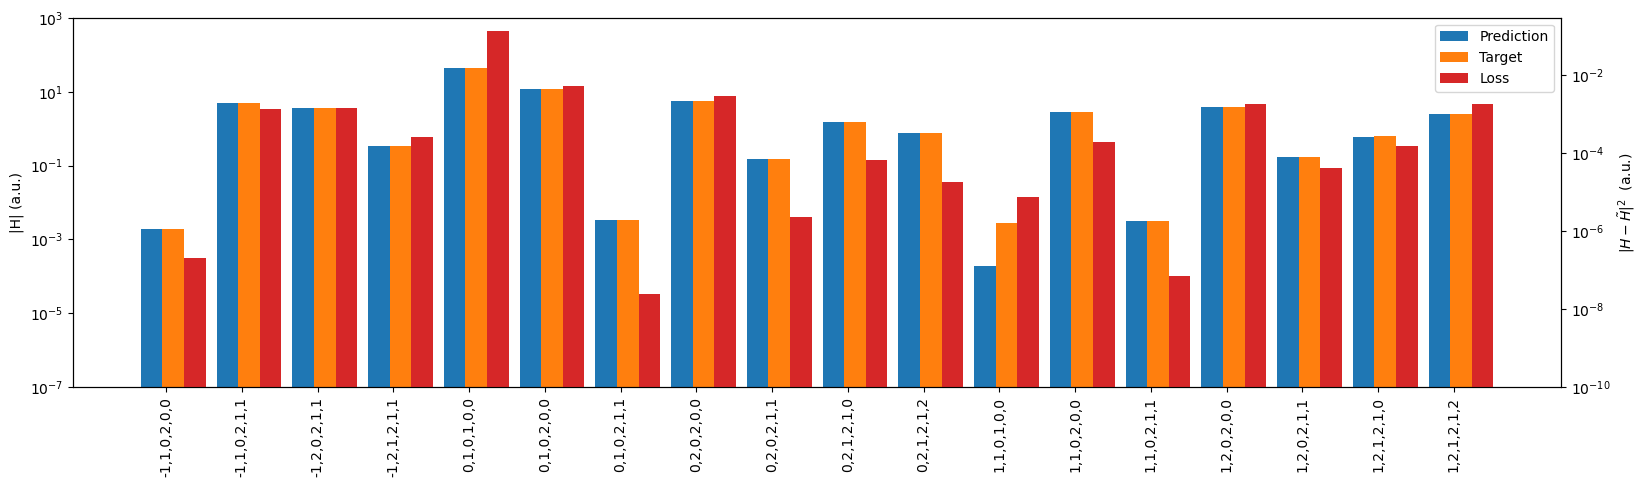

In [241]:
# pred = model.predict_batch(batch.descriptor)
for ib, batch in enumerate(dataloader):
    pred = model.predict_batch(batch.descriptor, batch.target)
    plot_block_errors(pred, batch.target, plot_loss=True)

In [88]:
pred = model()

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

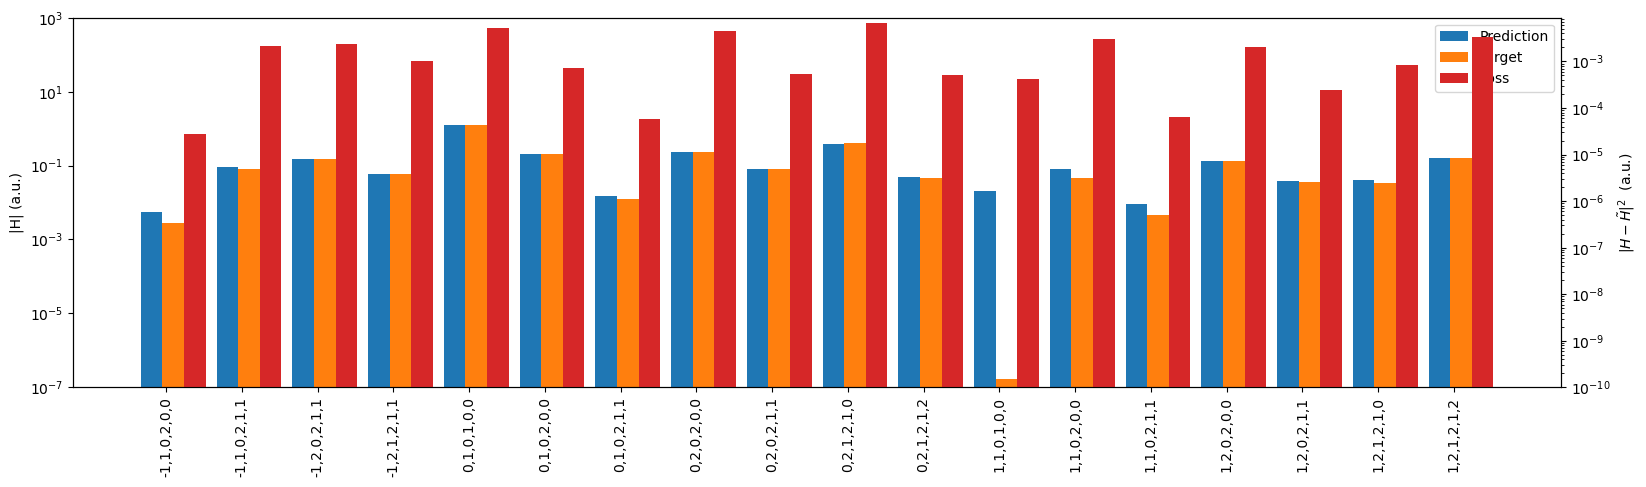

In [91]:
plot_block_errors(target_coupled_blocks, pred, plot_loss=True)

# Test

In [262]:
pred = model()

In [263]:
recon_HT = blocks_to_matrix(pred, dataset)
recon_Hk = dataset.bloch_sum(recon_HT)

In [264]:
overlaps_cutoff = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset))
fock_cutoff = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff), dataset))

In [265]:
from scipy.linalg import eigvalsh

eigvals_target = {}
eigvals_pred = {}

for A in range(len(dataset)):

    eigvals_target[A] = []
    eigvals_pred[A] = []
    
    for ik in range(len(dataset.fock_kspace[A])):
        # eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))

        # Target
        e = eigvalsh(fock_cutoff[A][ik].numpy(), overlaps_cutoff[A][ik].numpy())
        eigvals_target[A].append(e)
        
        # eigvals_target[A].append(e - e[0])
        e = eigvalsh(recon_Hk[A][ik].detach().numpy(), overlaps_cutoff[A][ik].numpy())
        eigvals_pred[A].append(e)
        # eigvals_pred[A].append(e - e[0])

0, 117: RMSE=0.326 a.u.
1, 119: RMSE=3.208 a.u.
2, 120: RMSE=1.591 a.u.
3, 122: RMSE=0.722 a.u.
4, 127: RMSE=2.281 a.u.


Text(0, 0.5, 'Predicted eigenvalues (a.u.)')

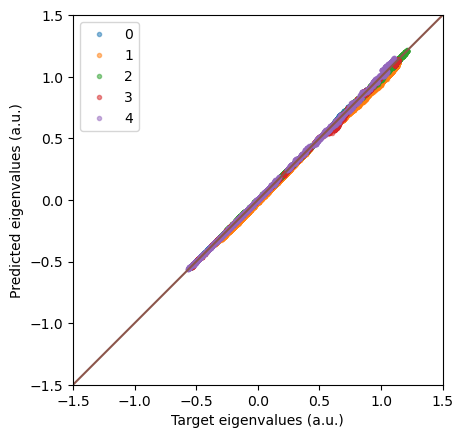

In [266]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A])
        print(f'{A}, {indices[A]}: RMSE={np.sqrt(np.linalg.norm(x-y)**2):.3f} a.u.')
        plt.plot(x, y, '.', alpha = 0.5, label = A)
ax.legend(loc = 'upper left')

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

# ax.set_xlim(-9.6,-9)
# ax.set_ylim(-9.6,-9)

ax.plot([-10,1.5], [-10,1.5])

ax.set_xlabel('Target eigenvalues (a.u.)')
ax.set_ylabel('Predicted eigenvalues (a.u.)')

0, 117: RMSE=0.209 a.u.
1, 119: RMSE=4.763 a.u.
2, 120: RMSE=1.386 a.u.
3, 122: RMSE=0.579 a.u.
4, 127: RMSE=2.151 a.u.


Text(0, 0.5, 'Predicted eigenvalues (a.u.)')

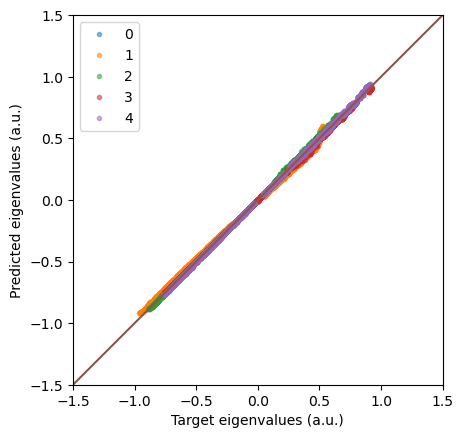

In [249]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A])
        print(f'{A}, {indices[A]}: RMSE={np.sqrt(np.linalg.norm(x-y)**2):.3f} a.u.')
        plt.plot(x, y, '.', alpha = 0.5, label = A)
ax.legend(loc = 'upper left')

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

# ax.set_xlim(-9.6,-9)
# ax.set_ylim(-9.6,-9)

ax.plot([-10,1.5], [-10,1.5])

ax.set_xlabel('Target eigenvalues (a.u.)')
ax.set_ylabel('Predicted eigenvalues (a.u.)')

## Load pretrained model

In [156]:
checkpoint = torch.load('/home/pegolo/Software/mlelec/examples/data/periodic/carbon_allotropes/model_allotropes_baselined_11800.ckpt')
# features = mts.load('/home/pegolo/Software/mlelec/examples/data/periodic/carbon_allotropes/features/all_features')
# target_coupled_blocks = mts.load('/home/pegolo/Software/mlelec/examples/data/periodic/carbon_allotropes/features/target_coupled_blocks_baselined')
# overlap_coupled_blocks = mts.load('/home/pegolo/Software/mlelec/examples/data/periodic/carbon_allotropes/features/overlap_coupled_blocks')

In [157]:
from mlelec.models.linear import LinearModelPeriodic
model = LinearModelPeriodic(twocfeat = features, 
                             target_blocks = target_coupled_blocks,
                             frames = dataset.structures, orbitals = dataset.basis, 
                             device = device,
                             bias = True,
                             nhidden = 64, 
                             nlayers = 1,
                             activation = 'SiLU',
                             apply_norm = True)
model = model.double()

In [158]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [159]:
pred = model.predict(features, target_coupled_blocks)

In [160]:
from mlelec.metrics import L2_loss, L2_loss_meanzero
loss_fn = L2_loss

In [161]:
L2_loss(pred, target_coupled_blocks)

tensor(0.7092, grad_fn=<AddBackward0>)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

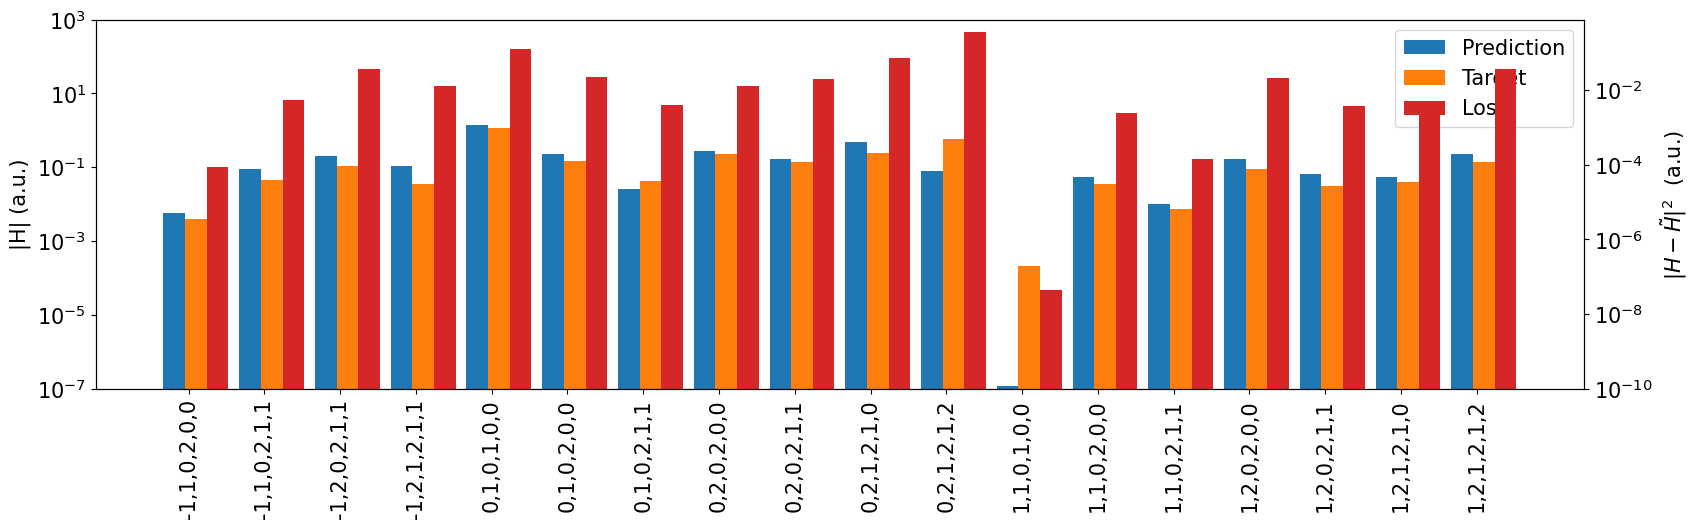

In [162]:
# pred = model()
plot_block_errors(pred, target_coupled_blocks, plot_loss=True)

In [163]:
overlaps_cutoff_graphene = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset))
fock_cutoff_graphene = dataset.bloch_sum(blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff), dataset))

In [164]:
recon_HT_graphene = blocks_to_matrix(pred, dataset)
recon_Hk_graphene = dataset.bloch_sum(recon_HT_graphene)

In [165]:
kfock0=dataset.bloch_sum(rfock0, is_tensor=False)

In [166]:
eigvals_target_graphene = {}
eigvals_pred_graphene = {}

for A in range(len(dataset)):

    eigvals_target_graphene[A] = []
    eigvals_pred_graphene[A] = []
    
    for ik in range(len(dataset.fock_kspace[A])):
        # eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))

        # Target
        e = eigvalsh(fock_cutoff_graphene[A][ik].numpy() + kfock0[A][ik].numpy() , overlaps_cutoff_graphene[A][ik].numpy())
        eigvals_target_graphene[A].append(e)
        
        # eigvals_target[A].append(e - e[0])
        e = eigvalsh(recon_Hk_graphene[A][ik].detach().numpy() + kfock0[A][ik].numpy(), overlaps_cutoff_graphene[A][ik].numpy())
        eigvals_pred_graphene[A].append(e)
        # eigvals_pred[A].append(e - e[0])

0, 303: RMSE=488.291 meV; MAE=297.777 meV
1, 304: RMSE=1317.629 meV; MAE=945.357 meV
2, 309: RMSE=353.362 meV; MAE=316.006 meV


Text(0, 0.5, 'Predicted eigenvalues (eV)')

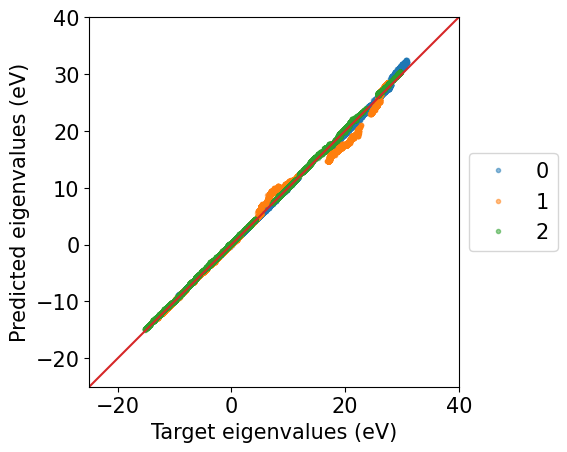

In [176]:
from ase.units import Hartree
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target_graphene:
    # if A != 2:
    if True:
        x, y = Hartree*np.concatenate(eigvals_target_graphene[A]), Hartree*np.concatenate(eigvals_pred_graphene[A])
        y=y[x>-100]
        x=x[x>-100]
        rmse = np.sqrt(np.mean((x-y)**2))*1000
        mae = np.mean(np.abs(x-y))*1000
        std = np.std(x)*1000
        # print(f'{A}, {indices[A]}: RMSE={rmse:.0f} meV')
        print(f'{A}, {indices[A]}: RMSE={rmse:.3f} meV; MAE={mae:.3f} meV')
        plt.plot(x, y, '.', alpha = 0.5, label = A)

ax.legend(loc = 'center left', bbox_to_anchor = (1,0.5))



# xmin, xmax = -275, 30 # All
# xmin, xmax = -275, -260 # core
xmin, xmax = -25, 40 # no core
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Predicted eigenvalues (eV)')

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Predicted eigenvalues (eV)')

In [178]:
0 in np.array([1,2])

False

In [96]:
tot = 0
for (k, p), t in zip(pred_from_allo.items(), tcb.blocks()):
    print(k.values)
    print(f'|p|={p.values.norm().item():.5f} |t|={t.values.norm().item():.5f}')
    print(f'|p-t|={(p.values-t.values).norm().item():.5f}')
    tot += (p.values-t.values).norm().item()
print(tot)

NameError: name 'pred_from_allo' is not defined

In [10]:
recon_HT = blocks_to_matrix(pred, dataset, detach = True)

In [11]:
for HT, H0 in zip(recon_HT, rfock0):
    for T in HT:
        HT[T] = HT[T].detach()
        HT[T] += H0[T]

In [12]:
recon_Hk = dataset.bloch_sum(recon_HT)

In [13]:
cutoff_overlaps = blocks_to_matrix(overlap_coupled_blocks, dataset)

In [14]:
recon_Sk = dataset.bloch_sum(cutoff_overlaps)

In [15]:
target_HT = []
for HT, H0 in zip(dataset.fock_realspace, rfock0):
    target_HT.append({})
    for T in HT:
        target_HT[-1][T] = HT[T] + H0[T]
target_Hk = dataset.bloch_sum(target_HT)

In [16]:
from scipy.linalg import eigvalsh
eigvals_target = {}
eigvals_pred = {}
for A in range(len(dataset)):
    eigvals_target[A] = []
    eigvals_pred[A] = []
    for ik in range(len(dataset.fock_kspace[A])):
        eigvals_target[A].append(eigvalsh(target_Hk[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))
        eigvals_pred[A].append(eigvalsh(recon_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))

0, 117: RMSE=7.12e-04 meV
1, 119: RMSE=1.69e-03 meV
2, 120: RMSE=2.71e-03 meV
3, 122: RMSE=1.52e-03 meV
4, 127: RMSE=4.34e-03 meV
5, 132: RMSE=2.63e-03 meV
6, 138: RMSE=3.03e-04 meV
7, 160: RMSE=1.99e-03 meV
8, 162: RMSE=2.13e-03 meV
9, 165: RMSE=8.34e-04 meV
10, 180: RMSE=5.68e-04 meV
11, 188: RMSE=3.51e-03 meV
12, 189: RMSE=2.17e-02 meV
13, 207: RMSE=1.59e-03 meV
14, 221: RMSE=2.71e-03 meV
15, 223: RMSE=2.06e-03 meV
16, 232: RMSE=1.74e-03 meV
17, 244: RMSE=1.86e-03 meV
18, 270: RMSE=2.38e-03 meV
19, 273: RMSE=2.21e-03 meV


Text(0.5, 1.0, '20 carbon allotropes. Baselined Hamiltonian training')

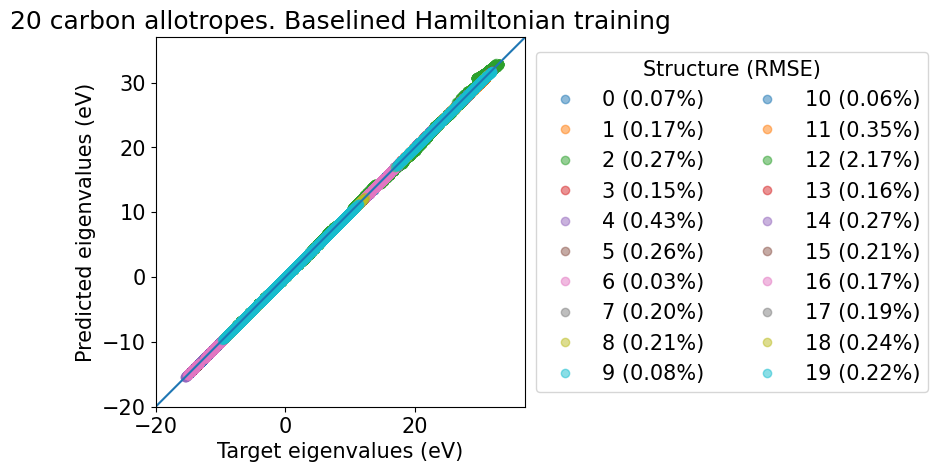

In [147]:
from ase.units import Hartree

plt.rcParams['font.size']=15
fig, ax = plt.subplots()

ax.set_aspect('equal')

for A in eigvals_target:
    # if A != 2:
    if True:
        x, y = Hartree*np.concatenate(eigvals_target[A]), Hartree*np.concatenate(eigvals_pred[A])
        y = y[x>-100]
        x = x[x>-100]
        rmse = np.sqrt(np.mean((x-y)**2)) / np.std(x)
        print(f'{A}, {indices[A]}: RMSE={rmse:.2e} meV')
        ax.plot(x, y, 'o', alpha = 0.5, label = f'{A} ({100*rmse:.2f}%)')
        # ax.plot(x, y, 'o', alpha = 0.5, label = f'{A} ({1000*np.sqrt(np.mean((x-y)**2)):.2f}meV)')
        
ax.legend(loc = 'center left', title = 'Structure (RMSE)', ncol = 2, bbox_to_anchor = (1,0.5))

# xmin, xmax = -275, 50 # All
# xmin, xmax = -260, -248 # core
xmin, xmax = -20, 37 # no core
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)

ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Predicted eigenvalues (eV)')
ax.set_title('20 carbon allotropes. Baselined Hamiltonian training')
# plt.xlim(-9.78,-9.7)
# plt.ylim(-9.78,-9.7)
# plt.xlim(-1,1.5)
# plt.ylim(-2,2)

In [56]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# Profile blocks_to_matrix

In [138]:
from mlelec.utils.pbc_utils import blocks_to_matrix, NEW_blocks_to_matrix

In [139]:
%lprun -f blocks_to_matrix blocks_to_matrix(target_coupled_blocks, dataset)

Timer unit: 1e-09 s

Total time: 17.2494 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py
Function: blocks_to_matrix at line 276

Line #      Hits         Time  Per Hit   % Time  Line Contents
   276                                           def blocks_to_matrix(blocks, dataset, device=None, cg = None, all_pairs = False, sort_orbs = True):
   277                                               ## WARNING: currently 'detaching' values before filling in matrices, so DONT train on reconstructed matrices
   278         1        581.0    581.0      0.0      if device is None:
   279         1       1092.0   1092.0      0.0          device = dataset.device
   280                                                   
   281         1     127230.0 127230.0      0.0      if "cell_shift_a" not in blocks.keys.names:
   282         1      14067.0  14067.0      0.0          assert "cell_shift_b" not in blocks.keys.names, "Weird! keys contain 'cell_shift_b' but not 'cell_shift_a'."
   2

In [145]:
%lprun -f NEW_blocks_to_matrix NEW_blocks_to_matrix(target_coupled_blocks, dataset)

Timer unit: 1e-09 s

Total time: 10.3548 s
File: /home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py
Function: NEW_blocks_to_matrix at line 1048

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1048                                           def NEW_blocks_to_matrix(blocks, dataset, device=None, sort_orbs = True, all_pairs = False, return_negative = False, cg = None):
  1049                                           
  1050         1        471.0    471.0      0.0      if device is None:
  1051         1       1052.0   1052.0      0.0          device = dataset.device
  1052                                                   
  1053                                               # if "cell_shift_a" not in blocks.keys.names:
  1054                                               #     assert "cell_shift_b" not in blocks.keys.names, "Weird! keys contain 'cell_shift_b' but not 'cell_shift_a'."
  1055                                               #     assert "cell_shift_

In [148]:
m1 = blocks_to_matrix(target_coupled_blocks, dataset)

In [149]:
m2 = NEW_blocks_to_matrix(target_coupled_blocks, dataset)

In [152]:
for m1_, m2_ in zip(m1, m2):
    for T in m1_:
        print(torch.norm(m1_[T]-m2_[T]))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)

# Meh

In [59]:
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

## Using tensormaps

In [65]:
split_features, split_target = split_by_Aij_mts(target_coupled_blocks, features = features)

In [66]:
ml_data = IndexedDataset(descriptor = list(split_features.values()), target = list(split_target.values()), sample_id = list(split_target.keys()))

In [111]:
batch_size = 20
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [92]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [112]:
kmap = []
for batch in dataloader:
    kmap.append(TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True))

## Check target and features decay

In [165]:
from mlelec.utils.plot_utils import block_matrix_norm, matrix_norm

In [179]:
rij, Hij = block_matrix_norm(tcb, dataset)

In [180]:
rij_S, Sij = block_matrix_norm(ocb, dataset)

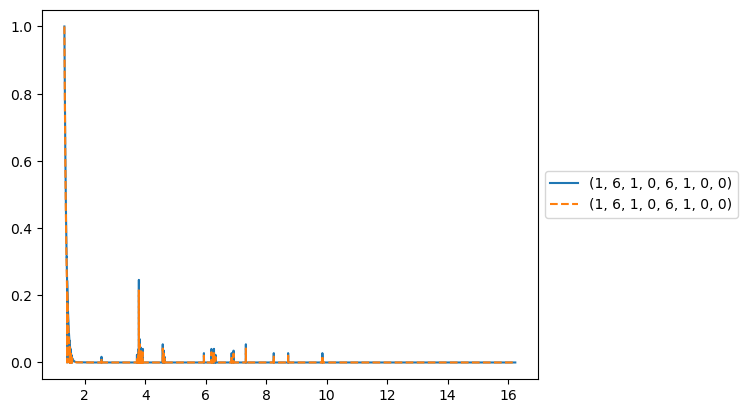

In [181]:
for k in rij:
    if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
        x = np.array(rij[k])
        y = np.array(Hij[k])[x.argsort()]
        plt.plot(x[x.argsort()], y/y[0], '-', label = k)

        x = np.array(rij_S[k])
        y = np.array(Sij[k])[x.argsort()]
        plt.plot(x[x.argsort()], y/y[0], '--', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [94]:
rij_, fij = block_matrix_norm(features, dataset)

In [260]:
from rascaline import SphericalExpansionByPair
from mlelec.features.acdc_utils import acdc_standardize_keys
gij = SphericalExpansionByPair(**hypers_pair).compute(frames)
gij = acdc_standardize_keys(gij)
rij_, fij = block_matrix_norm(gij, dataset)

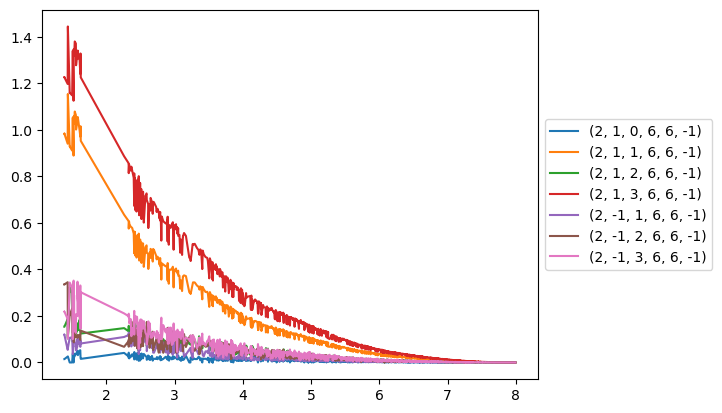

In [96]:
for k in rij_:
    # if k[0] == 1 and k[-1]==0 and k[3]==0 and k[5]==1:
    if k[-1]==-1:
    
        x = np.array(rij_[k])
        y = np.array(fij[k])
        plt.plot(x[x.argsort()], y[x.argsort()], '-', label = k)
# plt.ylim(-1e-3,1)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

In [148]:
ht = blocks_to_matrix(target_blocks, dataset)
ht_=[]
for ifr in range(len(rht)):
    ht_.append(torch.stack(list(ht[ifr].values())).flatten())
ht_ = torch.cat(ht_)

In [167]:
from ase.units import Hartree
lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()
lossfn(rht_,ht_)*Hartree*1000

tensor(0.1531)

## Debug samples mismatch

In [65]:
pred = model()

Check metadata

In [68]:
assert mts.equal_metadata(pred, target_coupled_blocks)

Check keys

In [69]:
target_coupled_blocks

TensorMap with 18 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          -1          6       1    0       6       2    0   0
          -1          6       1    0       6       2    1   1
          -1          6       2    0       6       2    1   1
          -1          6       2    1       6       2    1   1
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
          0           6       1    0       6       2    1   1
          0           6       2    0       6       2    0   0
          0           6       2    0       6       2    1   1
          0           6       2    1       6       2    1   0
          0           6       2    1       6       2    1   2
          1           6       1    0       6       1    0   0
          1           6       1    0       6       2    0   0
          1           6       1    0       6       2    1   1
          1           6       2    0       6 